In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import eli5
from eli5.sklearn import PermutationImportance

In [2]:
tips = pd.read_csv('tips.csv')

In [3]:
tips.head()

total_bill   tip     sex smoker  day    time  size
0       16.99  1.01  Female     No  Sun  Dinner     2
1       10.34  1.66    Male     No  Sun  Dinner     3
2       21.01  3.50    Male     No  Sun  Dinner     3
3       23.68  3.31    Male     No  Sun  Dinner     2
4       24.59  3.61  Female     No  Sun  Dinner     4

In [12]:
# 特征工程
def feature_engineering(df):
    # 复制数据框
    df_processed = df.copy()
    
    # 类别型变量编码
    categorical_columns = ['sex', 'smoker', 'day', 'time']
    le = LabelEncoder()
    
    for col in categorical_columns:
        df_processed[col] = le.fit_transform(df_processed[col])
    
    # 创建新特征
    df_processed['total_per_person'] = df_processed['total_bill'] / df_processed['size']
    
    return df_processed

In [13]:
# 数据处理
df_processed = feature_engineering(tips)

In [15]:
df_processed.head()

total_bill   tip  sex  smoker  day  time  size  total_per_person
0       16.99  1.01    0       0    2     0     2          8.495000
1       10.34  1.66    1       0    2     0     3          3.446667
2       21.01  3.50    1       0    2     0     3          7.003333
3       23.68  3.31    1       0    2     0     2         11.840000
4       24.59  3.61    0       0    2     0     4          6.147500

In [55]:
# 准备特征和目标变量
X = df_processed.drop(['tip'], axis=1)
y = df_processed['tip']>=3

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 训练随机森林模型
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [56]:
# 使用eli5计算特征重要性
perm = PermutationImportance(rf_model, random_state=42).fit(X_test, y_test)

# 显示特征重要性
print("特征重要性分析结果：")
print(eli5.format_as_text(eli5.explain_weights(perm, feature_names=X.columns.tolist())))

特征重要性分析结果：
Explained as: feature importances

Feature importances, computed as a decrease in score when feature
values are permuted (i.e. become noise). This is also known as 
permutation importance.

If feature importances are computed on the same data as used for training, 
they don't reflect importance of features for generalization. Use a held-out
dataset if you want generalization feature importances.

0.1959 ± 0.0952  total_bill
0.0408 ± 0.0577  smoker
0.0327 ± 0.0200  day
0.0327 ± 0.0554  sex
0.0204 ± 0.0258  size
0.0122 ± 0.0200  time
0.0082 ± 0.0327  total_per_person


In [51]:
from pdpbox import pdp, info_plots
import matplotlib.pyplot as plt

In [78]:
pdp_isolate = pdp.PDPIsolate(
            model=rf_model,
            df=X_test,
            model_features=X.columns.tolist(),
            feature_name = 'Total_bill',
            feature='total_bill')

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

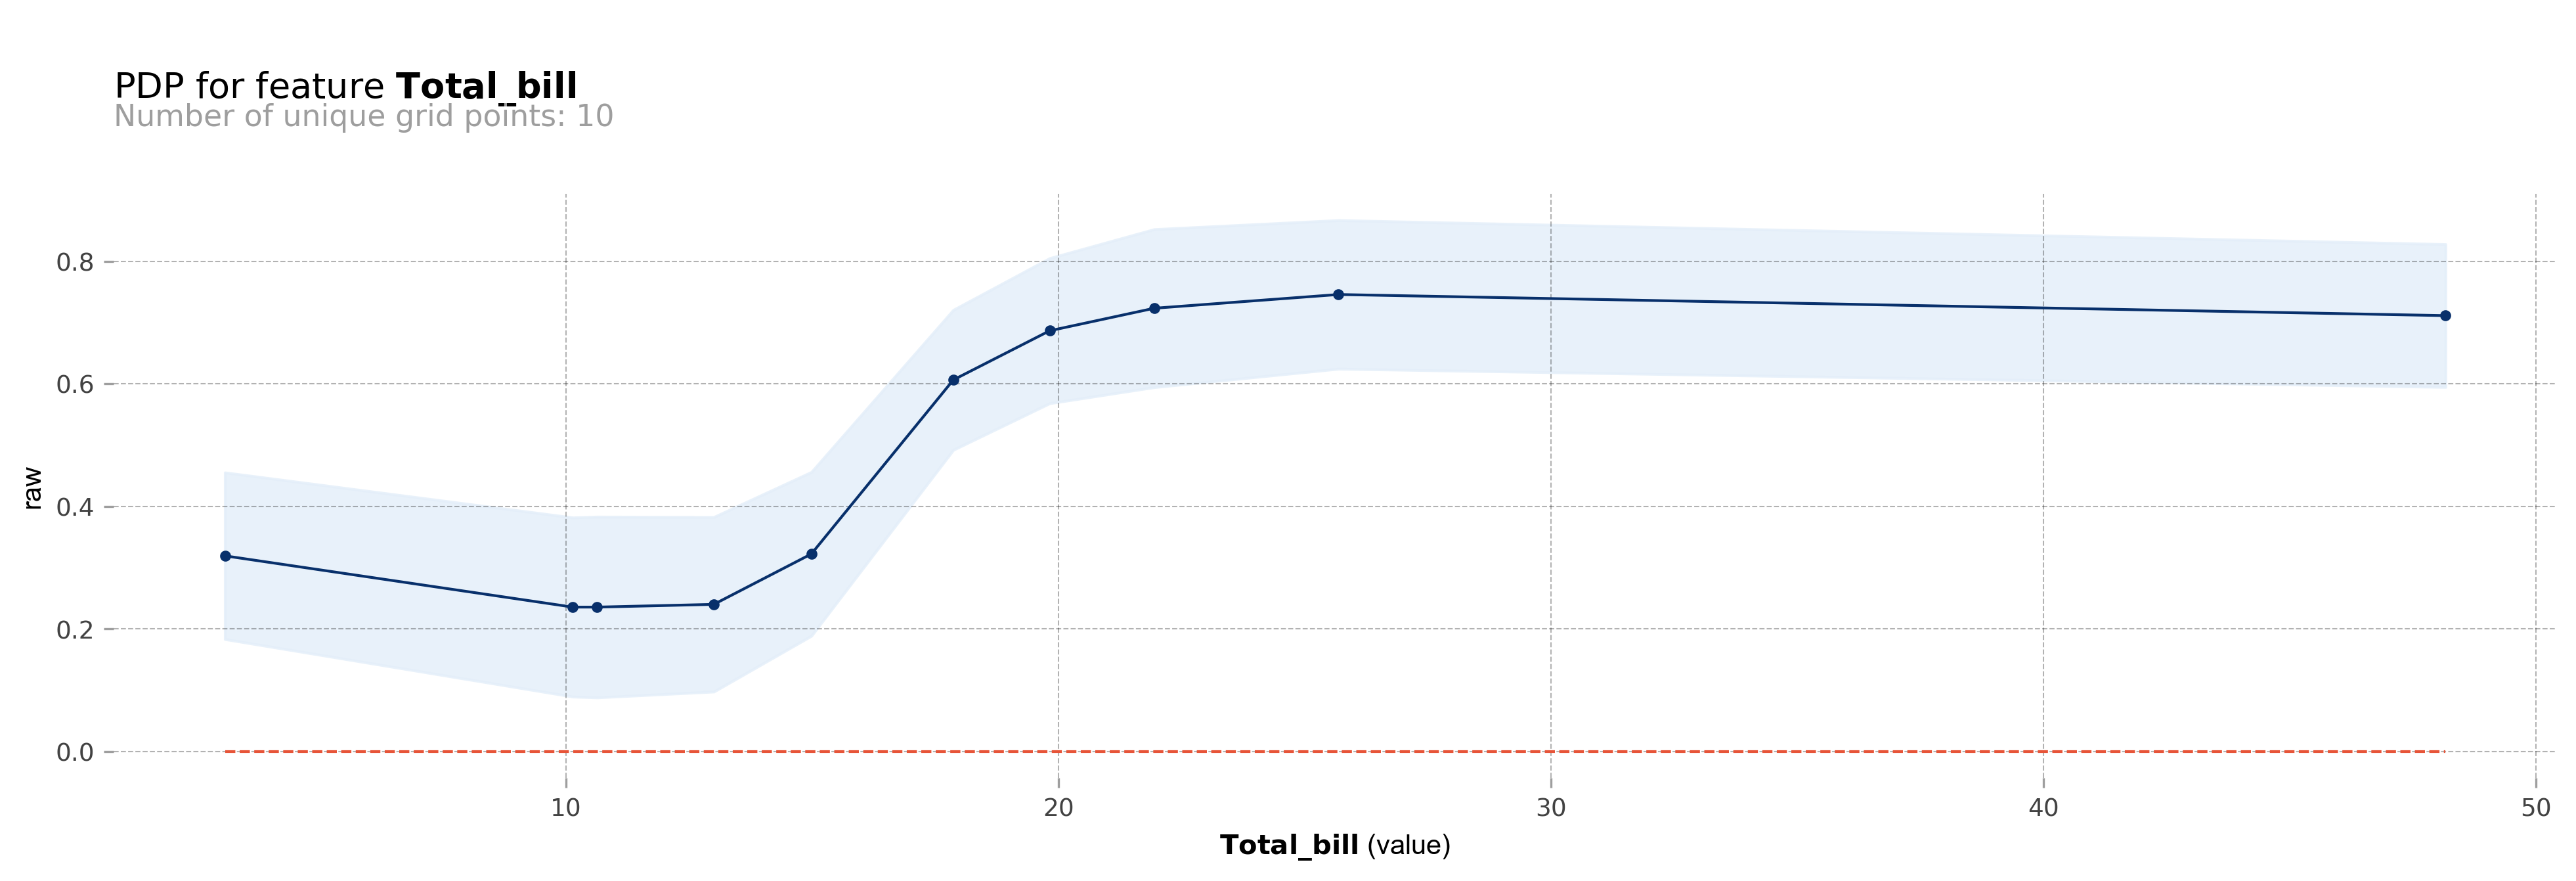

In [79]:
fig, axes = pdp_isolate.plot(
    center=False,
    plot_lines=False,
    plot_pts_dist=False,
    to_bins=False,
    engine='matplotlib',
)
fig.set_figheight(5)

In [82]:
pair = ('total_bill', 'size')

In [85]:
inter1 = pdp.PDPInteract(
            model=rf_model,
            df=X_test,
            model_features=X.columns.tolist(),
            features=pair,
            feature_names = ['Total_bill', 'Size']
        )

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/6 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/60 [00:00<?, ?it/s]

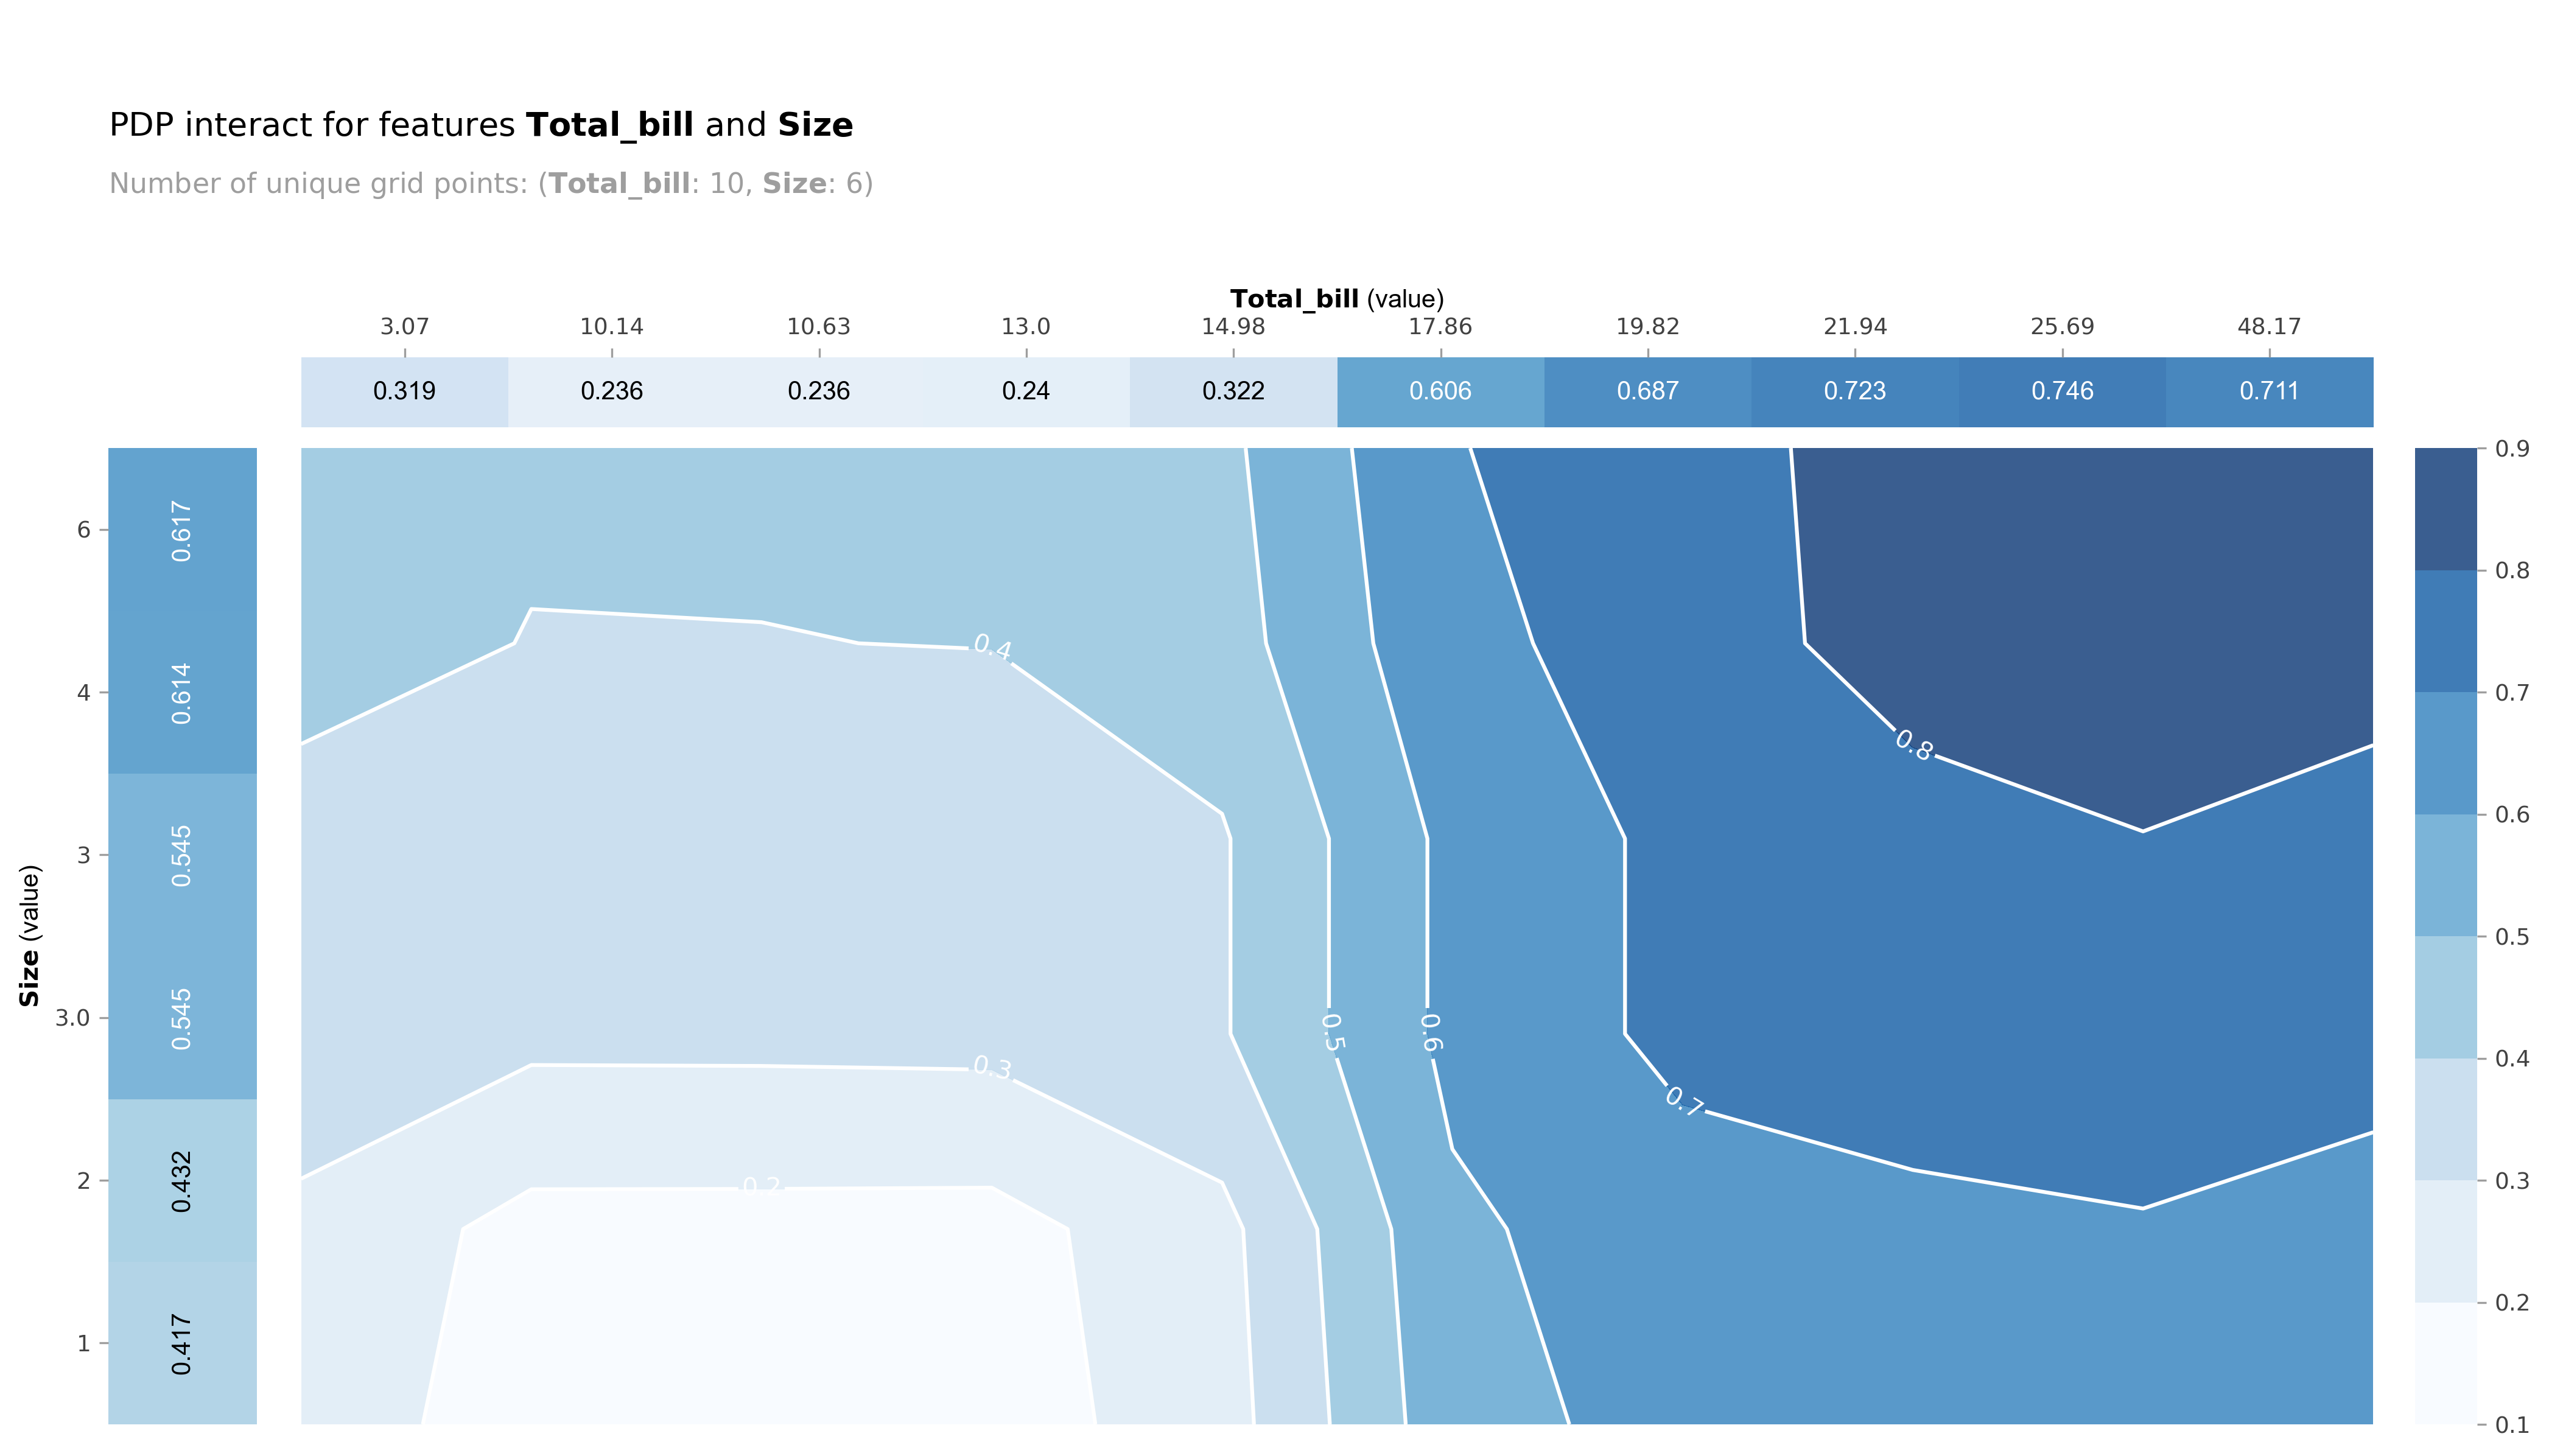

In [91]:
fig, axes = inter1.plot(
    plot_type='contour',
    plot_pdp=True,
    engine='matplotlib',
)
fig.set_figheight(10)

In [124]:
from lime.lime_tabular import LimeTabularExplainer  # 修改了导入语句

In [125]:
# 处理分类变量
categorical_features = ['sex', 'smoker', 'day', 'time']
tips_encoded = pd.get_dummies(tips, columns=categorical_features)

# 准备特征和目标变量
X = tips_encoded.drop('tip', axis=1)
y = tips['tip']

# 分割训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 训练随机森林模型
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 创建LIME解释器
explainer = LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns,
    class_names=['tip'],
    mode='regression'
)

<Figure size 1000x600 with 0 Axes>

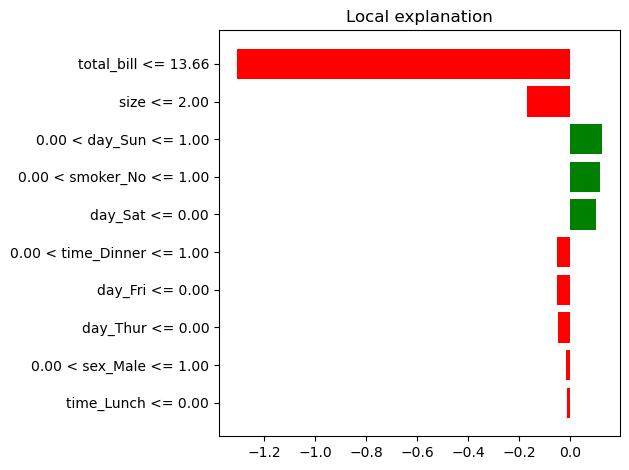

In [126]:
# 选择一个测试样本进行解释
instance_idx = 1
exp = explainer.explain_instance(
    X_test.iloc[instance_idx].values, 
    rf_model.predict,
    num_features=10
)

# 显示LIME解释结果
plt.figure(figsize=(10, 6))
exp.show_in_notebook(show_table=True)
exp.as_pyplot_figure()
plt.tight_layout()
plt.show()

In [127]:
# 打印实际值和预测值
print(f"实际小费金额: ${y_test.iloc[instance_idx]:.2f}")
print(f"预测小费金额: ${rf_model.predict([X_test.iloc[instance_idx]])[0]:.2f}")

# 显示特征重要性
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n特征重要性:")
print(feature_importance)

实际小费金额: $2.00
预测小费金额: $2.42

特征重要性:
        feature  importance
0    total_bill    0.759249
1          size    0.056902
4     smoker_No    0.045876
5    smoker_Yes    0.026808
7       day_Sat    0.026156
8       day_Sun    0.023658
3      sex_Male    0.016343
2    sex_Female    0.013059
11   time_Lunch    0.009036
10  time_Dinner    0.007823
6       day_Fri    0.007645
9      day_Thur    0.007444


In [129]:
# 处理分类变量
categorical_features = ['sex', 'smoker', 'day', 'time']
tips_encoded = pd.get_dummies(tips, columns=categorical_features)

# 准备特征和目标变量
X = tips_encoded.drop('tip', axis=1)
y = tips['tip'] > 3

# 分割训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 训练随机森林模型
rfC_model = RandomForestClassifier(n_estimators=100, random_state=42)
rfC_model.fit(X_train, y_train)

# 创建LIME解释器
explainer = LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns,
    class_names=['low', 'high'],
    mode='classification'
)

<Figure size 1000x600 with 0 Axes>

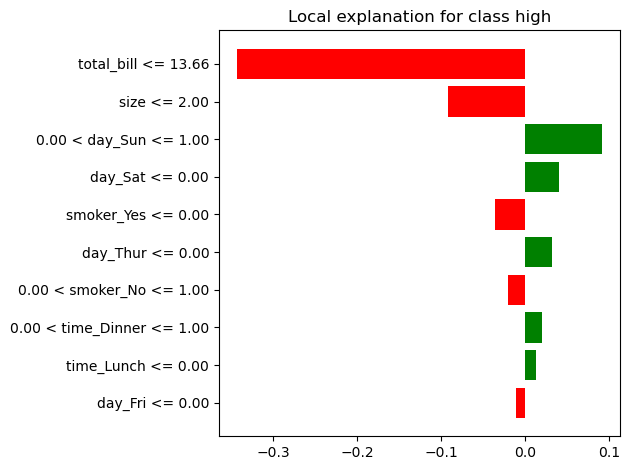

In [130]:
# 选择一个测试样本进行解释
instance_idx = 1
exp = explainer.explain_instance(
    X_test.iloc[instance_idx].values, 
    rfC_model.predict_proba,
    num_features=10
)

# 显示LIME解释结果
plt.figure(figsize=(10, 6))
exp.show_in_notebook(show_table=True)
exp.as_pyplot_figure()
plt.tight_layout()
plt.show()

In [139]:
# 打印实际值和预测值
print(f"实际小费类别(True>3,False<3): {y_test.iloc[instance_idx]}")
print(f"预测小费>3的概率: {rfC_model.predict_proba([X_test.iloc[instance_idx]])[0][1]}")

# 显示特征重要性
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rfC_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n特征重要性:")
print(feature_importance)

实际小费类别(True>3,False<3): False
预测小费>3的概率: 0.06

特征重要性:
        feature  importance
0    total_bill    0.653791
1          size    0.135539
8       day_Sun    0.039768
7       day_Sat    0.027599
5    smoker_Yes    0.025160
4     smoker_No    0.025083
3      sex_Male    0.022793
2    sex_Female    0.019747
6       day_Fri    0.014482
10  time_Dinner    0.012726
9      day_Thur    0.012449
11   time_Lunch    0.010864


In [15]:
from sklearn.ensemble import RandomForestRegressor
import shap
import matplotlib.pyplot as plt

In [4]:
tips.head()

total_bill   tip     sex smoker  day    time  size
0       16.99  1.01  Female     No  Sun  Dinner     2
1       10.34  1.66    Male     No  Sun  Dinner     3
2       21.01  3.50    Male     No  Sun  Dinner     3
3       23.68  3.31    Male     No  Sun  Dinner     2
4       24.59  3.61  Female     No  Sun  Dinner     4

In [5]:
# 处理分类变量
categorical_features = ['sex', 'smoker', 'day', 'time']
tips_encoded = pd.get_dummies(tips, columns=categorical_features)

In [6]:
tips_encoded.head()

total_bill   tip  size  sex_Female  sex_Male  smoker_No  smoker_Yes  \
0       16.99  1.01     2        True     False       True       False   
1       10.34  1.66     3       False      True       True       False   
2       21.01  3.50     3       False      True       True       False   
3       23.68  3.31     2       False      True       True       False   
4       24.59  3.61     4        True     False       True       False   

   day_Fri  day_Sat  day_Sun  day_Thur  time_Dinner  time_Lunch  
0    False    False     True     False         True       False  
1    False    False     True     False         True       False  
2    False    False     True     False         True       False  
3    False    False     True     False         True       False  
4    False    False     True     False         True       False

In [18]:
# 准备特征和目标变量
X = tips_encoded.drop('tip', axis=1)
y = tips['tip']

In [13]:
# 分割训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 训练随机森林模型
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 计算SHAP值
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

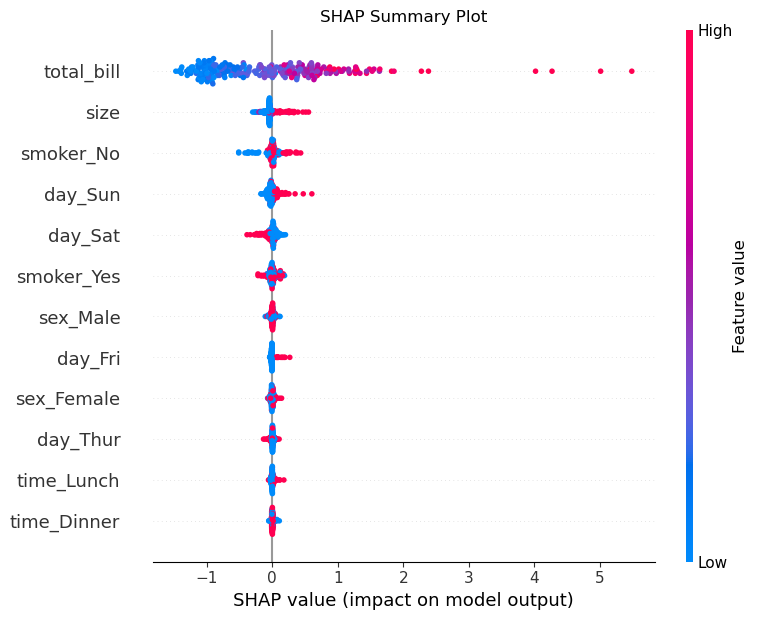

<Figure size 640x480 with 0 Axes>

In [24]:
# 1. SHAP概要图
plt.figure(figsize=(10, 8))
plt.title('SHAP Summary Plot')
shap.summary_plot(shap_values, X)
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

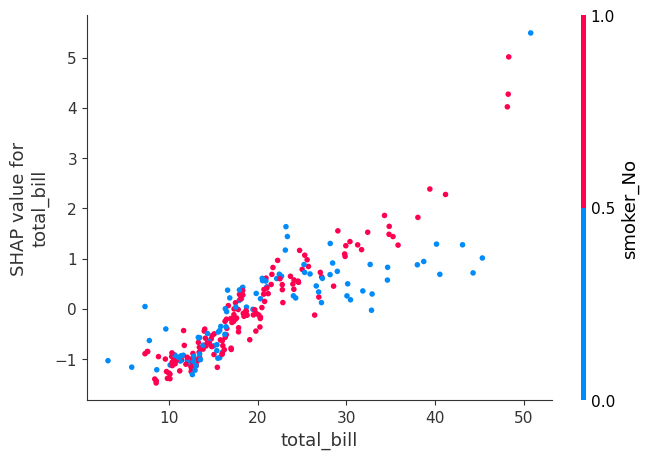

<Figure size 640x480 with 0 Axes>

In [36]:
# 2. SHAP依赖图（以total_bill为例）
plt.figure(figsize=(10, 6))
shap.dependence_plot('total_bill', shap_values, X)
# plt.title('SHAP Dependence Plot for Total Bill')
plt.tight_layout()
plt.show()

<Figure size 1200x400 with 0 Axes>

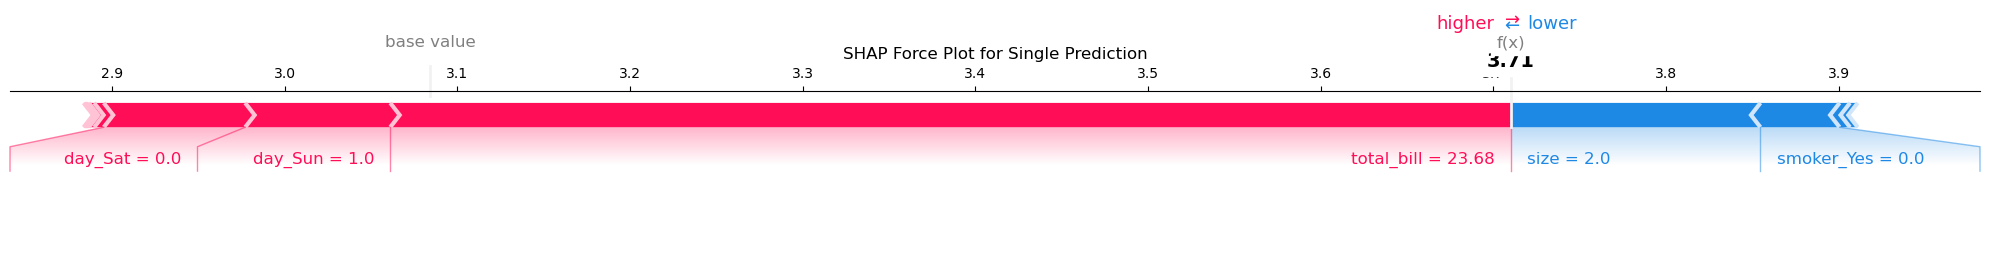

In [43]:
# 3. SHAP力图 - 选择一个具体样本进行解释
sample_idx = 3
plt.figure(figsize=(12, 4))
shap.force_plot(explainer.expected_value, shap_values[sample_idx], X.iloc[sample_idx],
                matplotlib=True, show=False)
plt.title('SHAP Force Plot for Single Prediction')
plt.tight_layout()
plt.show()

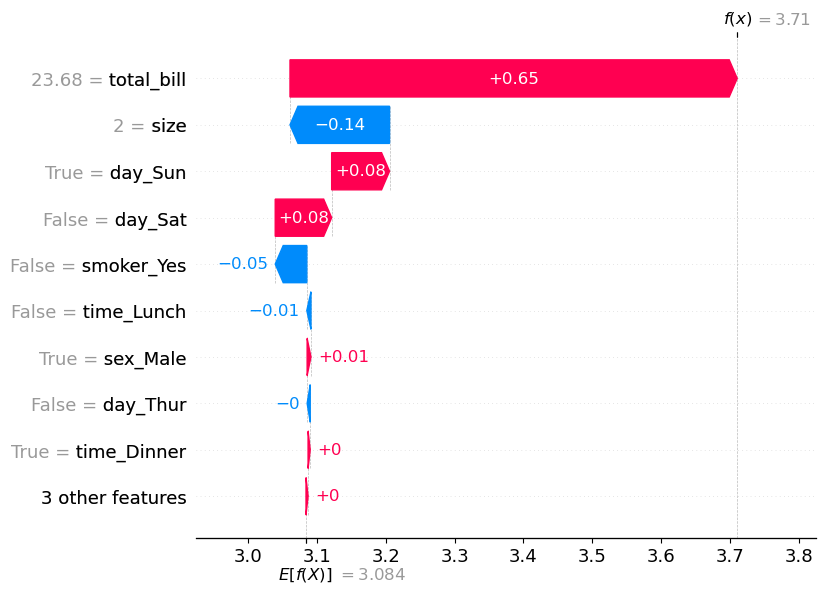

<Figure size 640x480 with 0 Axes>

In [44]:
# 4. SHAP瀑布图 - 显示具体样本的预测过程
plt.figure(figsize=(10, 6))
shap.waterfall_plot(shap.Explanation(values=shap_values[sample_idx], 
                                   base_values=explainer.expected_value,
                                   data=X.iloc[sample_idx],
                                   feature_names=X.columns))
# plt.title('SHAP Waterfall Plot')
plt.tight_layout()
plt.show()

In [29]:
# 5. 计算并显示每个特征的平均绝对SHAP值
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': np.abs(shap_values).mean(axis=0)
}).sort_values('importance', ascending=False)

print("\n特征重要性（基于平均绝对SHAP值）:")
print(feature_importance)


特征重要性（基于平均绝对SHAP值）:
        feature  importance
0    total_bill    0.781437
1          size    0.087323
4     smoker_No    0.066797
8       day_Sun    0.053452
7       day_Sat    0.052372
5    smoker_Yes    0.041960
3      sex_Male    0.018594
6       day_Fri    0.017610
2    sex_Female    0.017071
9      day_Thur    0.015501
11   time_Lunch    0.013545
10  time_Dinner    0.009546


In [30]:
# 6. 为某个具体预测显示详细的特征贡献
sample_prediction = model.predict(X_test.iloc[[sample_idx]])[0]
print(f"\n样本 #{sample_idx} 的预测详情:")
print(f"预测小费金额: ${sample_prediction:.2f}")
print(f"实际小费金额: ${y_test.iloc[sample_idx]:.2f}")


样本 #0 的预测详情:
预测小费金额: $2.83
实际小费金额: $3.18


In [31]:
# 7. 显示该样本的特征值
print("\n该样本的特征值:")
for feature, value in X_test.iloc[sample_idx].items():
    if value != 0:  # 只显示非零值（对于one-hot编码的特征很有用）
        print(f"{feature}: {value:.2f}")


该样本的特征值:
total_bill: 19.82
size: 2.00
sex_Male: 1.00
smoker_No: 1.00
day_Sat: 1.00
time_Dinner: 1.00


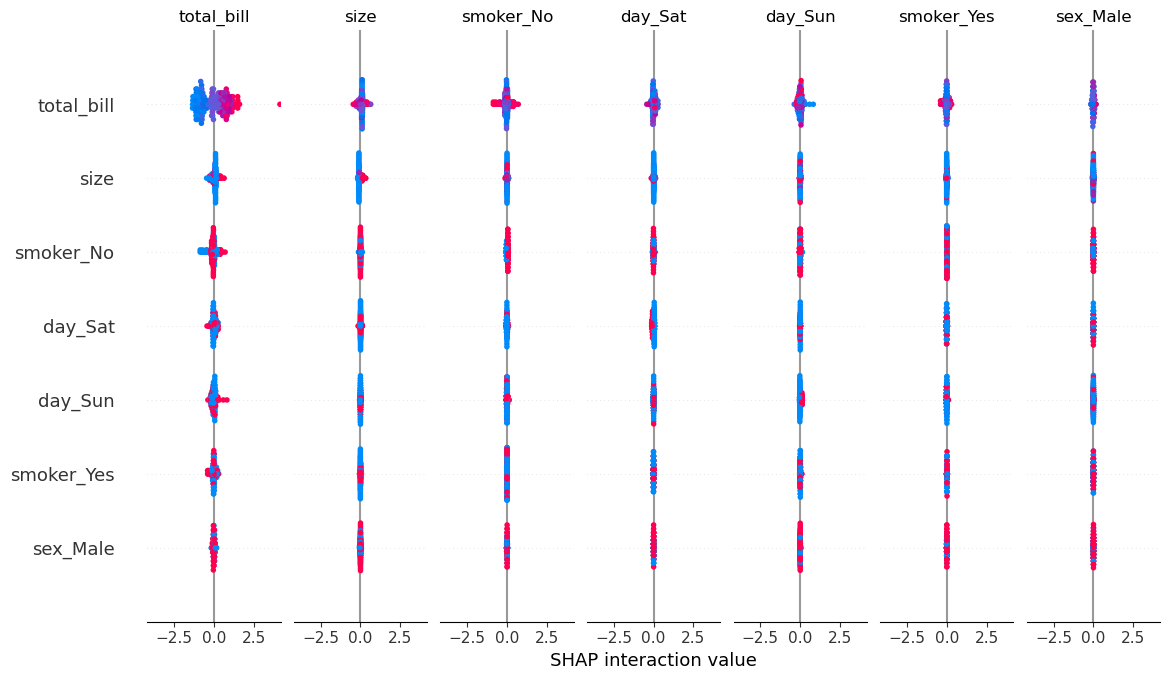

In [39]:
# 8.交互作用
shap_interaction_values = explainer.shap_interaction_values(X_train)
shap.summary_plot(shap_interaction_values, X_train)

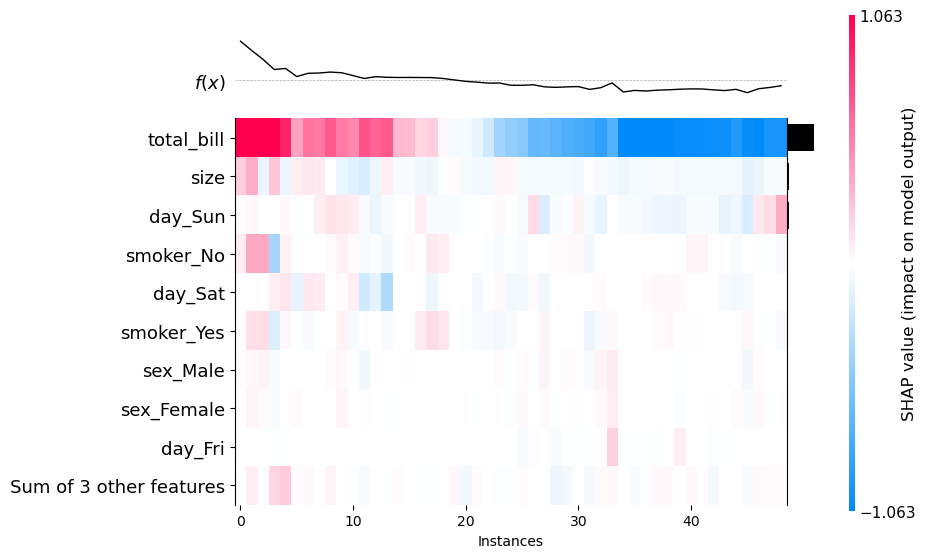

<Axes: xlabel='Instances'>

In [47]:
# 9. SHAP热图（Heatmap）
shap_values_test = explainer.shap_values(X_test)
# 创建 shap.Explanation 对象
shap_explanation = shap.Explanation(values=shap_values_test, 
                                    base_values=explainer.expected_value, 
                                    data=X_test.iloc, feature_names=X_test.columns)
# 绘制热图
shap.plots.heatmap(shap_explanation)